In [1]:
import json
import graphviz
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
f_automated = open('data/automatedAccountData.json')
f_nonautomated = open('data/nonautomatedAccountData.json')

In [3]:
data_automated = json.load(f_automated)
data_nonautomated = json.load(f_nonautomated)
data = data_automated + data_nonautomated

In [4]:
print(list(data_automated[0].keys()))

['userMediaCount', 'mediaLikeNumbers', 'mediaCommentNumbers', 'mediaCommentsAreDisabled', 'mediaHashtagNumbers', 'mediaUploadTimes', 'mediaHasLocationInfo', 'userFollowerCount', 'userFollowingCount', 'userHasHighlighReels', 'userHasExternalUrl', 'userTagsCount', 'userBiographyLength', 'usernameLength', 'usernameDigitCount', 'automatedBehaviour']


## Like distribution
because we have the number of likes for each post of the users, we can check for like distribution. this will help us to determine how to handle the number of likes in our dataset.

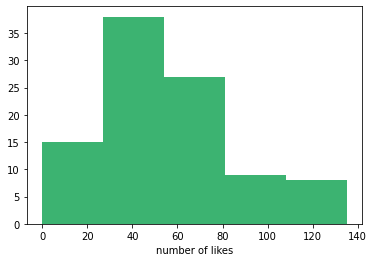

In [5]:
account_idx = 0
likes_array = np.asarray(data[account_idx]['mediaLikeNumbers'], dtype=np.int32)
plt.hist(likes_array, 5, range=(0, likes_array.max()), facecolor='mediumseagreen')
plt.xlabel('number of likes')
plt.show()

## Comment distribution

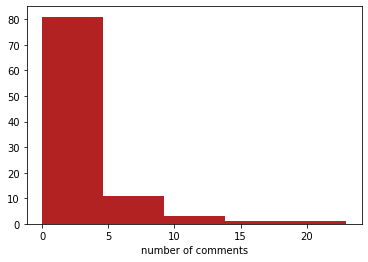

In [6]:
account_idx = 0
comments_array = np.asarray(data[account_idx]['mediaCommentNumbers'], dtype=np.int32)
plt.hist(comments_array, 5, range=(0, comments_array.max()), facecolor='firebrick')
plt.xlabel('number of comments')
plt.show()

## Hashtag distribution

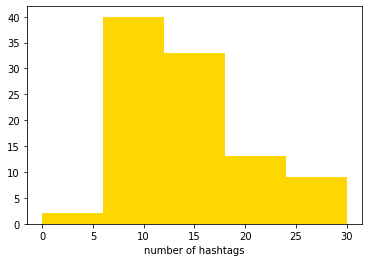

In [7]:
account_idx = 0
hashtag_array = np.asarray(data[account_idx]['mediaHashtagNumbers'], dtype=np.int32)
plt.hist(hashtag_array, 5, range=(0, hashtag_array.max()), facecolor='gold')
plt.xlabel('number of hashtags')
plt.show()

## Media upload interval distribution

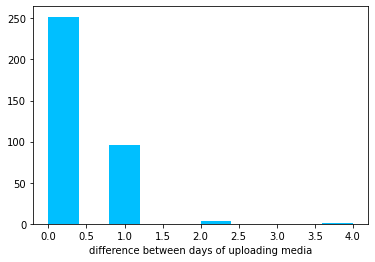

In [8]:
account_idx = 32
upload_times = data[account_idx]['mediaUploadTimes']
upload_dtimes = []
for t in upload_times:
    upload_dtimes.append(datetime.datetime.fromtimestamp(t))

post_upload_intervals = []
for i in range(1, len(upload_dtimes)):
    post_upload_intervals.append((upload_dtimes[i - 1].date() - upload_dtimes[i].date()).days)
    
plt.hist(post_upload_intervals, facecolor='deepskyblue')
plt.xlabel('difference between days of uploading media')
plt.show()

## Media upload hour distribution

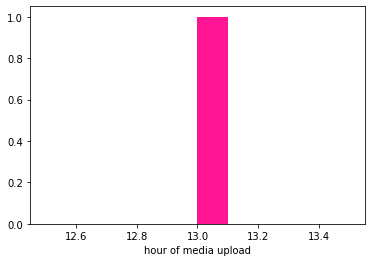

In [9]:
account_idx = -1
upload_dtimes = []
for t in data[account_idx]['mediaUploadTimes']:
    upload_dtimes.append(datetime.datetime.fromtimestamp(t))

upload_hours = []
for t in upload_dtimes:
    upload_hours.append(t.time().hour)
    
plt.hist(upload_hours, facecolor='deeppink')
plt.xlabel('hour of media upload')
plt.show()

In [10]:
accounts_list = []
for account in data:
    # median of like numbers
    medLikeNumbers = 0
    if len(account['mediaLikeNumbers']) != 0:
        medLikeNumbers = np.median(account['mediaLikeNumbers'])
    
    # median of comment numbers
    medCommentNumbers = 0
    if len(account['mediaCommentNumbers']) != 0:
        medCommentNumbers = np.median(account['mediaCommentNumbers'])
    
    # median of hashtag numbers
    medHashtagNumbers = 0
    if len(account['mediaHashtagNumbers']) != 0:
        medHashtagNumbers = np.median(account['mediaHashtagNumbers'])
    
    # median of difference between media uploads
    medUploadIntervals = np.nan
    upload_dtimes = []
    for t in account['mediaUploadTimes']:
        upload_dtimes.append(datetime.datetime.fromtimestamp(t))

    post_upload_intervals = []
    for i in range(1, len(upload_dtimes)):
        post_upload_intervals.append((upload_dtimes[i - 1].date() - upload_dtimes[i].date()).days)
        
    if len(post_upload_intervals) != 0:
        medUploadIntervals = np.median(post_upload_intervals)
        
    # median of hour of media upload
    medUploadHour = np.nan
    upload_hours = []
    for t in upload_dtimes:
        upload_hours.append(t.time().hour)
    
    if len(upload_hours) != 0:
        medUploadHour = np.median(upload_hours)
    
    tmp_account = pd.Series({
        'userMediaCount': account['userMediaCount'],
        'medLikeNumbers':  medLikeNumbers,
        'medCommentNumbers': medCommentNumbers,
        'countCommentsAreDisabled': np.sum(account['mediaCommentsAreDisabled']),
        'medHashtagNumbers': medHashtagNumbers,
        'medUploadIntervals': medUploadIntervals,
        'medUploadHours': medUploadHour,
        'countHasLocationInfo': np.sum(account['mediaHasLocationInfo']),
        'followerCount': account['userFollowerCount'],
        'followingCount': account['userFollowingCount'],
        'hasHighlightReels': account['userHasHighlighReels'],
        'hasExternalUrl': account['userHasExternalUrl'],
        'tagCounts': account['userTagsCount'],
        'biographyLength': account['userBiographyLength'],
        'usernameLength': account['usernameLength'],
        'usernameDigitCount': account['usernameDigitCount'],
        'isFake': account['automatedBehaviour']
    })
    accounts_list.append(tmp_account)
df = pd.DataFrame.from_records(accounts_list)

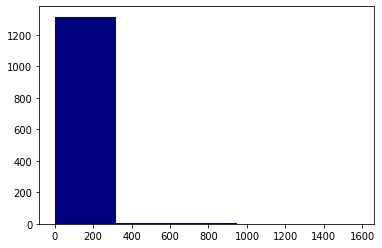

In [11]:
plt.hist(df['medUploadIntervals'], 5, range=(0, df['medUploadIntervals'].max()), facecolor='navy')
plt.show()
medUserUploadIntervals = df['medUploadIntervals'].median(skipna=True)
df['medUploadIntervals'] = df['medUploadIntervals'].fillna(medUserUploadIntervals)

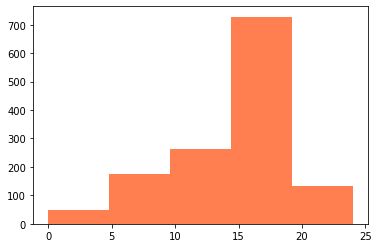

In [12]:
plt.hist(df['medUploadHours'], 5, range=(0, 24), facecolor='coral')
plt.show()
medUserUploadHours = df['medUploadHours'].median(skipna=True)
df['medUploadHours'] = df['medUploadHours'].fillna(medUserUploadHours)

In [13]:
df = shuffle(df)
df.head()

,userMediaCount,medLikeNumbers,medCommentNumbers,countCommentsAreDisabled,medHashtagNumbers,medUploadIntervals,medUploadHours,countHasLocationInfo,followerCount,followingCount,hasHighlightReels,hasExternalUrl,tagCounts,biographyLength,usernameLength,usernameDigitCount,isFake
1358,36.0,63.0,1.0,0.0,0.0,18.0,17.0,8.0,273.0,404.0,0.0,0.0,22.0,0.0,12.0,0.0,0.0
52,38.0,101.0,3.0,10.0,0.0,6.0,13.0,26.0,1246.0,1245.0,0.0,0.0,5.0,28.0,5.0,3.0,1.0
762,23.0,79.0,0.0,0.0,0.0,5.0,20.0,15.0,273.0,217.0,1.0,0.0,2.0,40.0,7.0,0.0,0.0
1067,119.0,22.0,0.0,0.0,0.0,3.0,17.0,60.0,546.0,509.0,1.0,0.0,34.0,134.0,8.0,0.0,0.0
560,212.0,72.5,2.0,0.0,0.0,3.0,9.0,20.0,2423.0,1374.0,1.0,0.0,53.0,144.0,11.0,2.0,1.0


In [14]:
df.to_csv('fake-profile-dataset.csv', index=False)

In [15]:
X = df.drop(['isFake'], axis=1)
y = df['isFake']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
clf = tree.DecisionTreeClassifier(min_samples_split=20, max_depth=10, random_state=42)
clf = clf.fit(X_train, y_train)

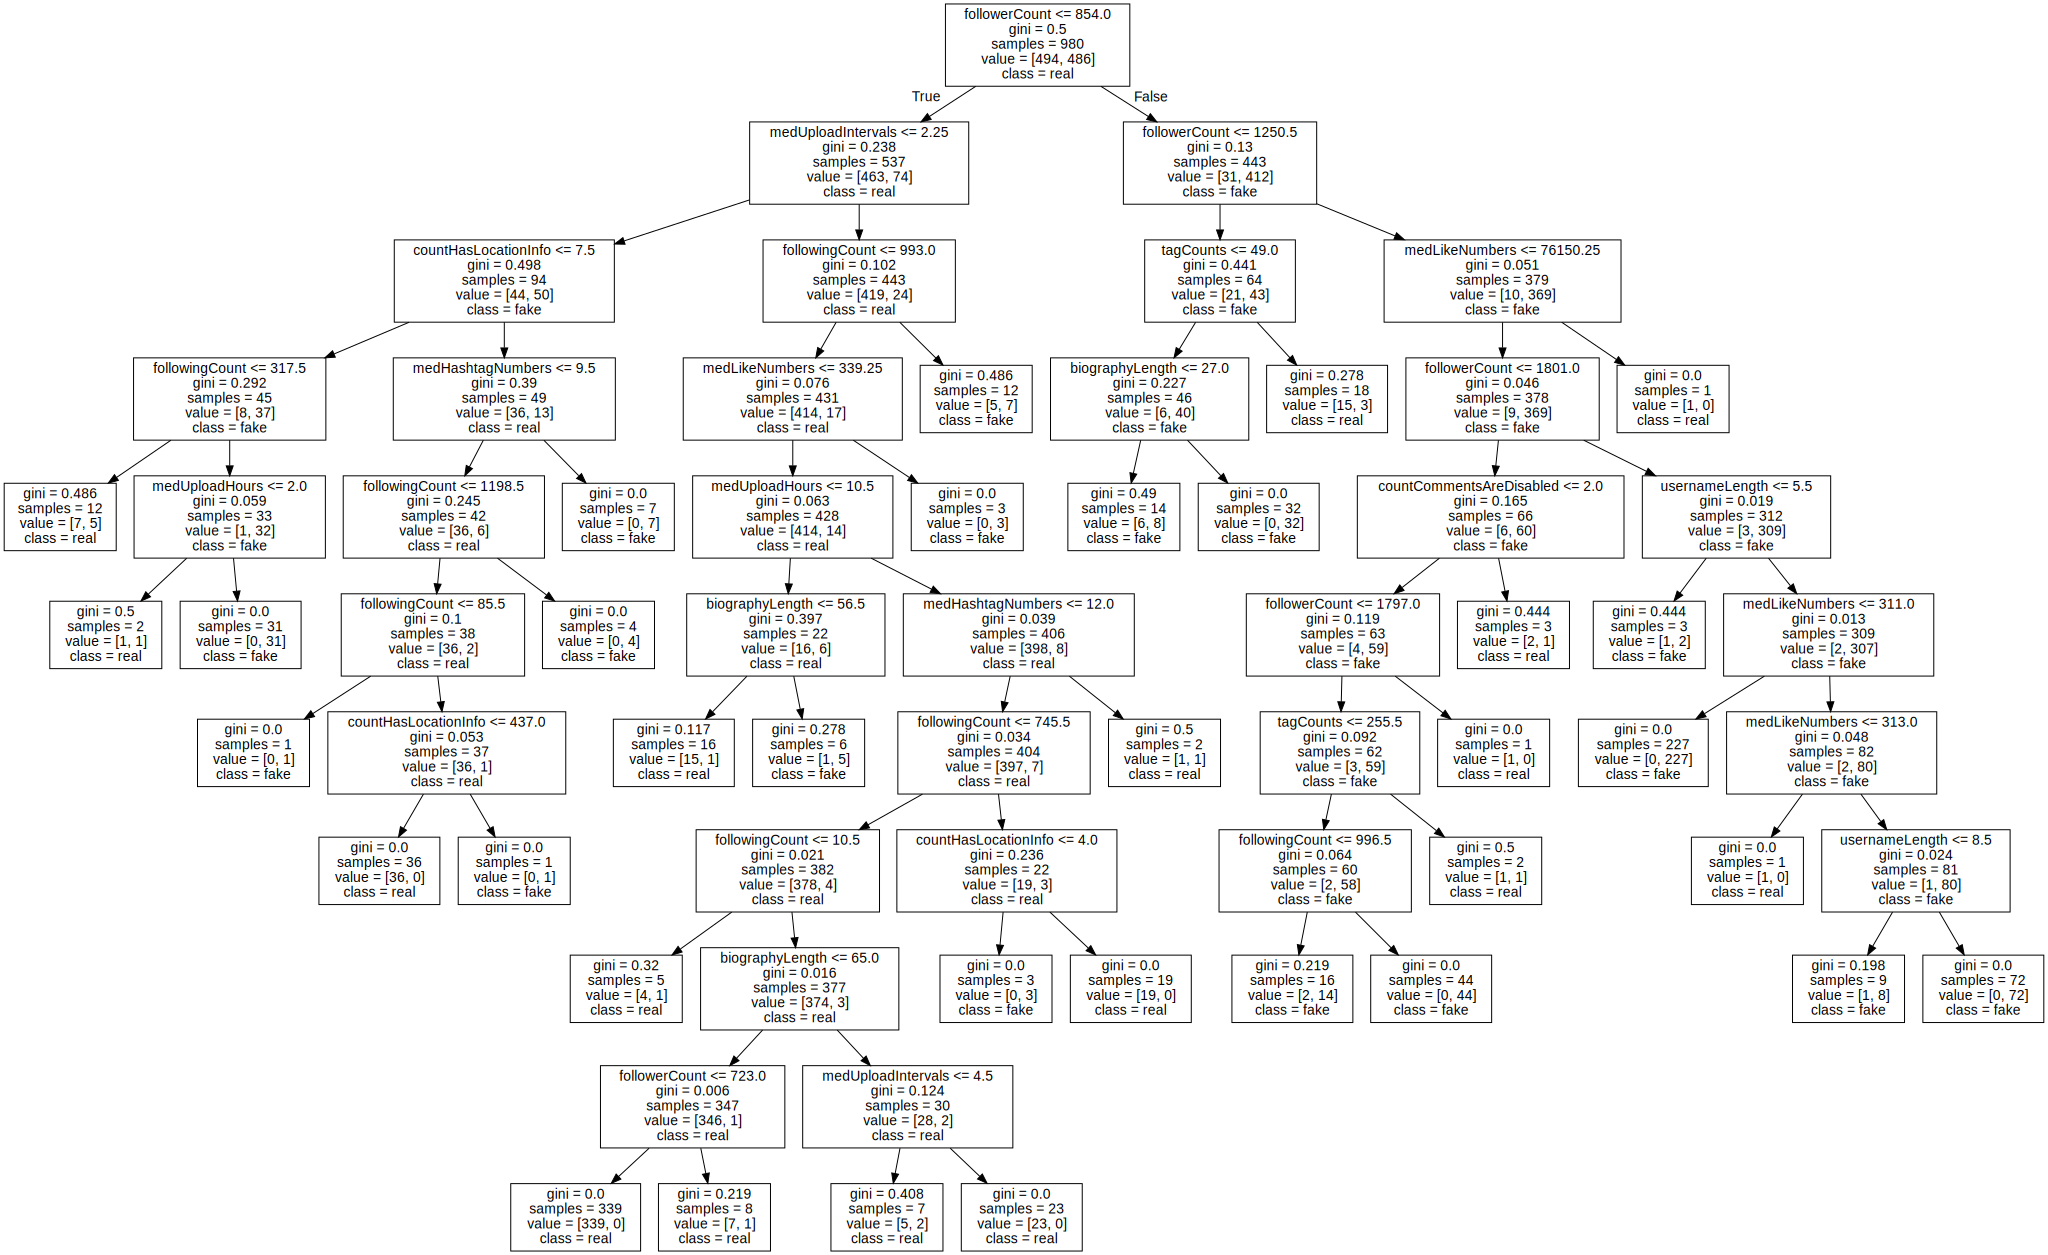

In [17]:
dot_data = tree.export_graphviz(clf,
                                feature_names=X.columns.tolist(),
                                class_names=['real', 'fake'],
                                out_file=None)
graph = graphviz.Source(dot_data)
graph.render(filename='decision-tree')
graph

In [18]:
print("train accuracy:\t", clf.score(X_train, y_train))
print("test accuracy:\t", clf.score(X_test, y_test))

train accuracy:	 0.9663265306122449
test accuracy:	 0.919047619047619


In [19]:
print("height:\t", clf.get_depth())

height:	 10


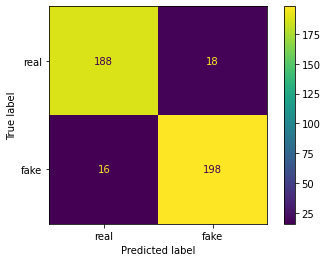

In [20]:
cm = confusion_matrix(y_test, clf.predict(X_test))
cmd = ConfusionMatrixDisplay(cm, display_labels=['real', 'fake'])
cmd.plot()

In [21]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92       206
         1.0       0.92      0.93      0.92       214

    accuracy                           0.92       420
   macro avg       0.92      0.92      0.92       420
weighted avg       0.92      0.92      0.92       420

